In [1]:
COMMIT_HASH = "9c3ef18c821268297f31d45e36c3b0f2bb538a80"
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip3.12 install ./
%cd ./..
!rm -Rf dgm_utils

Клонирование в «dgm_utils»...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 121 (delta 73), reused 80 (delta 37), pack-reused 0 (from 0)
Получение объектов: 100% (121/121), 24.71 КиБ | 496.00 КиБ/с, готово.
Определение изменений: 100% (73/73), готово.
/Users/petr12375/Documents/mipt/implicit-reparameterization-trick/code/dgm_utils
Примечание: переключение на «9c3ef18c821268297f31d45e36c3b0f2bb538a80».

Вы сейчас в состоянии «отсоединённого указателя HEAD». Можете осмотреться,
внести экспериментальные изменения и зафиксировать их, также можете
отменить любые коммиты, созданные в этом состоянии, не затрагивая другие
ветки, переключившись обратно на любую ветку.

Если хотите создать новую ветку для сохранения созданных коммитов, можете
сделать это (сейчас или позже), используя команду switch с параметром -c.
Например:

  git switch -c <новая-ветка>

Или отмените эту операцию с помощью:

/Users/petr12375/Documents/mipt/implicit-reparameterization-trick/irt/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Processing /Users/petr12375/Documents/mipt/implicit-reparameterization-trick/code/dgm_utils
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached setuptools-75.2.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 8.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 MB 9.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

In [2]:
from dgm_utils import train_model
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

import numpy as np
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

/Users/petr12375/Documents/mipt/implicit-reparameterization-trick/irt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


GPU not found :(


# ResNetVAE on CIFAR10 data 

100%|██████████| 170M/170M [00:50<00:00, 3.39MB/s] 


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


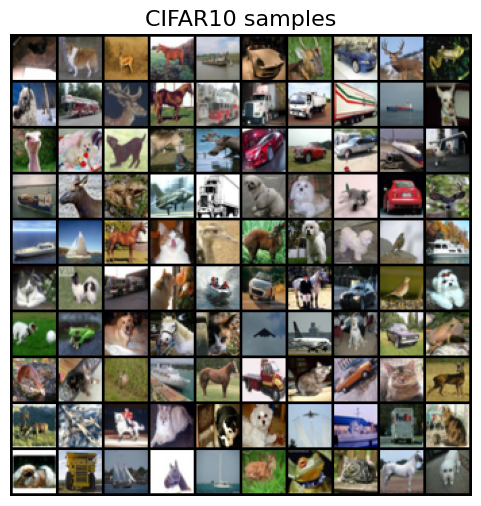

In [3]:
train_data, test_data = load_dataset("cifar10", flatten=False, binarize=False)
visualize_images(train_data, "CIFAR10 samples")

Now it is time to define our model. Our model will have the following structure:

* Prior distribution is standard Normal ($p(\mathbf{z}) = \mathcal{N}(0, I)$).
* Variational posterior distribution (or encoder) is $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$. Here $\boldsymbol{\phi}$ denotes all parameters of the encoder neural network. We will assume that covariance matrice $\boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x})$ is diagonal.
* Generative distribution (or decoder) is $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$. Here $\boldsymbol{\theta}$ denotes all parameters of the decoder neural network. Please note, that here we will use continuous distribution for our variables $\mathbf{x}$.
* We do not fit the covariance matrix $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ in the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$. We assume that it is identical ($\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{I}$). We will use the $\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z})$ (mean of the generative distribution $p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$) as model samples.
* Our encoder and decoder will be convolutional neural networks.
* Model objective is slightly modified ELBO:
$$
    \mathcal{L}(\boldsymbol{\phi}, \boldsymbol{\theta}) = \mathbb{E}_{q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta}) - \beta * KL (q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) || p(\mathbf{z})).
$$
Here we introduce the parameter $\beta$. It reweights KL term in the total loss. It a standard heuristics that allows to get more accurate model. In this exercise you have to play with it, starting with the value $\beta = 1$ (standard ELBO).

To make the expectation is independent of parameters $\boldsymbol{\phi}$, we will use reparametrization trick.


To calculate the loss, we should derive
- $\log p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$, note that generative distribution is $\mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}), \boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}))$.
- KL between $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}(\mathbf{x}), \boldsymbol{\Sigma}_{\boldsymbol{\phi}}(\mathbf{x}))$ and $\mathcal{N}(0, \mathbf{I})$.

Let start with the helper functions.

In [4]:
def get_normal_KL(
    mean_1: torch.Tensor,
    log_std_1: torch.Tensor,
    mean_2: Optional[torch.Tensor] = None,
    log_std_2: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    :Parameters:
    mean_1: means of normal distributions (1)
    log_std_1 : standard deviations of normal distributions (1)
    mean_2: means of normal distributions (2)
    log_std_2 : standard deviations of normal distributions (2)
    :Outputs:
    kl divergence of the normal distributions (1) and normal distributions (2)
    ---
    This function should return the value of KL(p1 || p2),
    where p1 = Normal(mean_1, exp(log_std_1) ** 2), p2 = Normal(mean_2, exp(log_std_2) ** 2).
    If mean_2 and log_std_2 are None values, we will use standard normal distribution.
    Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    assert mean_1.shape == log_std_1.shape == mean_2.shape == log_std_2.shape
    # ====
    # your code
    # define KL divergence of normal distributions
    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)

    var_1 = std_1 ** 2
    var_2 = std_2 ** 2

    D_KL = 0.5 * (
        (var_1 / var_2) +
        ((mean_2 - mean_1) ** 2 / var_2) -
        1 +
        torch.log(var_2 / var_1)
    )
    return D_KL
    # ====


def test_KL():
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)
        ).numpy(),
        200.2144,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_KL(
            torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)
        ).numpy(),
        1.50925,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_KL(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        [49.2990, 1498.479],
        rtol=1e-3,
    )


test_KL()

In [5]:
def get_normal_nll(
    x: torch.Tensor, mean: torch.Tensor, log_std: torch.Tensor
) -> torch.Tensor:
    """
    This function should return the negative log likelihood log p(x),
    where p(x) = Normal(x | mean, exp(log_std) ** 2).
    Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    # your code
    # implement negative log likelihood
    std = torch.exp(log_std)
    log_likelihood = torch.log(
        1 / ((2 * torch.pi)**0.5 * std) *
        torch.exp(-0.5 * ((x - mean) ** 2) / (std ** 2))
    )
    return -log_likelihood
    # ====


def test_NLL():
    assert np.isclose(
        get_normal_nll(torch.tensor(2), torch.tensor(2), torch.tensor(3)).numpy(),
        3.9189,
        rtol=1e-3,
    )
    assert np.isclose(
        get_normal_nll(torch.tensor(5), torch.tensor(-3), torch.tensor(6)).numpy(),
        6.9191,
        rtol=1e-3,
    )
    assert np.allclose(
        get_normal_nll(
            torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))
        ).numpy(),
        np.array([3.9982, 5.9197]),
        rtol=1e-3,
    )


test_NLL()

Let define our encoder and decoder neural networks. We will use ResNet-like encoder and decoder.

First of all let define basic ResNet block. It will be the basic block for our encoder.

In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, final_relu=True):
        super().__init__()
        self.final_relu = final_relu
        # ====
        # your code
        # here you could try different network structures
        # we suggest to use the following:
        # residual(x) = conv(bn(relu(conv(bn(x)))))
        # output = relu(conv1x1(input) + residual(input))
        # ====
        out_padding = int((kernel_size - 1) / 2)

        if stride == 1:
          padding = int((kernel_size - stride) / 2)
        else:
          padding = int((kernel_size - stride) / 2) + 1

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=out_padding)
        )
        self.skip = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
        )
        self.gelu = nn.GELU()
        if final_relu:
          self.relu2 = nn.ReLU()

    def forward(self, x):
        # ====
        # your code
        # use here defined layers
        result = self.gelu(self.residual(x) + self.skip(x))
        # ====
        if self.final_relu:
            result = self.relu2(result)
        return result


def test_resnet_block():
    test_inp = torch.randn(5, 64, 128, 128)

    for out_channels in [64, 128]:
        for kernel_size in [3, 5, 7]:
            for stride in [1, 2, 4]:
                resnet_block = ResNetBlock(in_channels=64, out_channels=out_channels,
                                        kernel_size=kernel_size, stride=stride)
                assert list(resnet_block(test_inp).shape) == [5, out_channels, 128 // stride, 128 // stride]


test_resnet_block()

Now let define basic ResNet block. It will be the basic block for our decoder.

In [7]:
class ResNetTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, final_relu=True):
        super().__init__()
        self.final_relu = final_relu
        # ====
        # your code
        # here you could try different network structures
        # we suggest to use the following:
        # output = conv(bn(f(input))) + f(input), where:
        # f(x) = upconv(bn(x))
        out_padding = kernel_size - 1
        padding = (kernel_size - stride) // 2

        self.f = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=out_padding, dilation=2)
        )
        # ====
        if self.final_relu:
          self.relu1 = nn.ReLU()

    def forward(self, x):
        # ====
        # your code
        f = self.f(x)
        result = self.conv(f) + f
        # ====
        if self.final_relu:
            result = self.relu1(result)
        return result


def test_resnet_transposed_block():
    test_inp = torch.randn(5, 64, 64, 64)
    for out_channels in [64, 128]:
        for kernel_size in [4, 6, 8]:
            for stride in [2, 4]:
                resnet_block = ResNetTransposeBlock(
                    in_channels=64, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
                assert list(resnet_block(test_inp).shape) == [5, out_channels, 64 * stride, 64 * stride]


test_resnet_transposed_block()

Now we are to define our encoder and decoder.

In [8]:
class ConvResNetEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super().__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        # ====
        # your code
        # our suggestions:
        # - try to combine multiple resnet blocks
        # - place Flatten + Linear at the end
        self.encoder = self.cnn_layers = nn.Sequential(
            ResNetBlock(input_shape[0], 8, 3, 1, True),
            ResNetBlock(8, 16, 3, 1, True),
            ResNetBlock(16, 64, 5, 2, True),
            ResNetBlock(64, 128, 7, 4, False),
            nn.Flatten(),
            nn.Linear(128 * (input_shape[1] // 8) * (input_shape[2] // 8), 4096), 
            nn.ReLU(),
            nn.Linear(4096, n_latent * 2)
        )
        # ====

    def forward(self, x):
        # ====
        # your code
        # apply all blocks defined in init
        # split output tensor to mu and log_std
        output = self.encoder(x)
        mu, log_std = output.chunk(2, dim=1)
        # ====
        return mu, log_std


class ConvResNetDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super().__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape
        # ====
        # your code
        # our suggestions:
        # - apply linear layer to the input
        # - reshape output matrix to 4-dims tensor
        # - try to combine multiple resnet transposed blocks
        self.decoder = nn.Sequential(
            nn.Linear(n_latent, 4096),
            nn.ReLU(),
            nn.Linear(4096, 128 * (output_shape[1] // 8) * (output_shape[2] // 8)),
            nn.ReLU(),
            nn.Unflatten(1, torch.Size((128, output_shape[1] // 8, output_shape[2] // 8))),
            ResNetTransposeBlock(128, 64, 4, 2, final_relu=True),
            ResNetTransposeBlock(64, 16, 4, 2, final_relu=True),
            ResNetTransposeBlock(16, 8, 4, 2, final_relu=True),
            ResNetTransposeBlock(8, self.output_shape[0], 3, 1, final_relu=False)
        )
        # ====

    def forward(self, z):
        # ====
        # your code
        # apply all blocks defined in init
        out = self.decoder(z)
        # ====
        return out


def test_convresnet_models():
    test_enc = ConvResNetEncoder((3, 32, 32), n_latent=10)
    inp = torch.randn((4, 3, 32, 32))
    mu, std = test_enc(inp)
 
    assert list(mu.shape) == [4, 10]
    assert list(std.shape) == [4, 10]

    test_dec = ConvResNetDecoder(10, (3, 32, 32))
    inp = torch.randn(4, 10)
    assert list(test_dec(inp).shape) == [4, 3, 32, 32]


test_convresnet_models()

We are ready to implement VAE model for image dataset.

In [ ]:
torch.distributions

In [ ]:
class ConvResNetVAE(BaseModel):
    def __init__(self, input_shape: tuple, n_latent: int, beta: float = 1) -> None:
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta

        # ====
        # your code
        # define encoder and decoder
        self.encoder = ConvResNetEncoder(input_shape, n_latent)
        self.decoder = ConvResNetDecoder(n_latent, input_shape)
        # ====

    def prior(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # return n samples from prior distribution (we use standart normal for prior)
        z = torch.randn(n, self.n_latent)
        # ====
        z = z.to(self.device)
        return z

    def forward(self, x: torch.Tensor) -> tuple:
        # ====
        # your code
        # 1) apply encoder to get mu_z, log_std_z
        # 2) apply reparametrization trick (use self.prior)
        # 3) apply decoder to get mu_x (which corresponds to reconstructed x)
        mu_z, log_std_z = self.encoder(x)
        z = self.prior(x.shape[0]) * torch.exp(log_std_z) + mu_z
        x_recon = self.decoder(z)
        # ====
        return mu_z, log_std_z, x_recon

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # 1) make forward step to get mu_z, log_std_z, x_recon
        # 2) calculate recon_loss (use get_normal_nll)
        # 3) calcucalte kl_loss (use get_normal_KL)
        mu_z, log_std_z, x_recon = self.forward(x)
        recon_loss = get_normal_nll(x, x_recon, torch.zeros_like(x_recon)).sum(dim=(1,2,3)).mean()
        kl_loss = get_normal_KL(mu_z, log_std_z).sum(dim=1).mean()
        # ====
        return {
            "elbo_loss": recon_loss + self.beta * kl_loss,
            "recon_loss": recon_loss,
            "kl_loss": kl_loss,
        }

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():
            # ====
            # your code
            # 1) generate prior samples
            # 2) apply decoder
            sample = self.prior(n)
            x_recon = self.decoder(sample)
            # ====
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

That is all! We are ready to train our model.

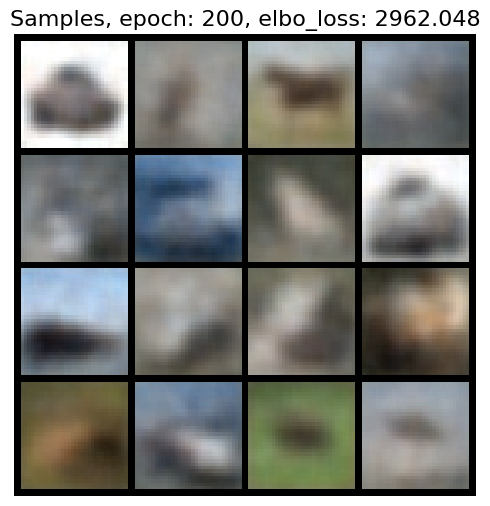

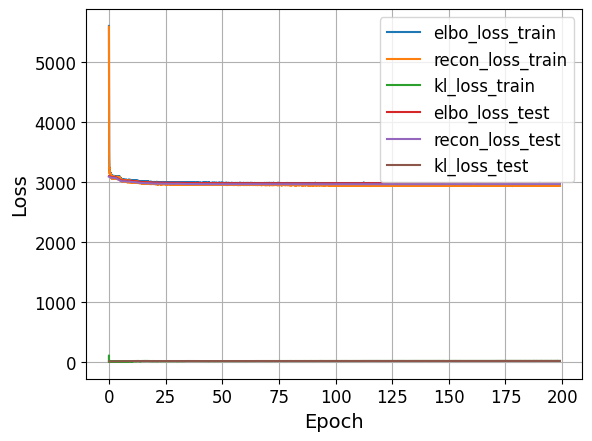

End of the training


In [ ]:
# ====
# your code
# choose these parameters

BATCH_SIZE = 256 # any adequate value
EPOCHS = 200  # < 16
LR = 1e-3  # < 1e-3
N_LATENS = 1024  # 128 < _ < 1024
BETA = 1.  # 0.1 < _ < 10
# ====

# we center the data, because it helps the model to fit
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvResNetVAE((3, 32, 32), N_LATENS, BETA)

# ====
# your code
# choose any optimizer/scheduler as you want
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# ====

train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    device=DEVICE,
    n_samples=16,
    visualize_samples=True,
    loss_key="elbo_loss"
)

Now we could visualize the model outputs.

1. We could sample new images from our model (sample latent variable from the prior and apply the decoder).
2. We could visualize image reconstructions (apply the encoder and the decoder to the fixed image).
3. Visualize interpolations (apply the encoder to two images $\mathbf{x}_1$ and $\mathbf{x}_2$ to obtain the latent variables $\mathbf{z}_1$ and $\mathbf{z}_2$, apply the decoder to the latent variables $\mathbf{z}$ lying on the segment between $\mathbf{z}_1$ and $\mathbf{z}_2$).

**Note:** it is ok that your samples are blurry. We do not use difficult architectures and do not tune hyperparameters carefully.

In [ ]:
torch.save(model, 'vae.pth')

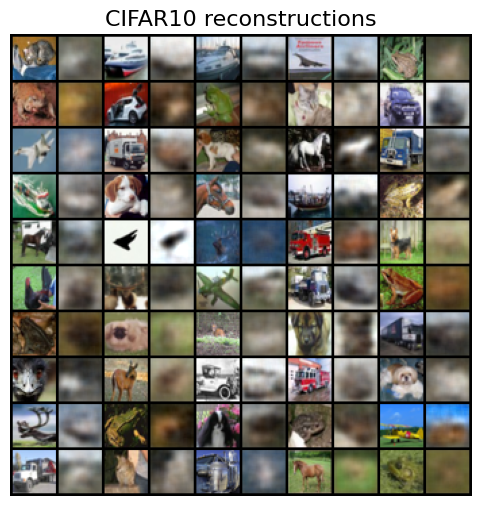

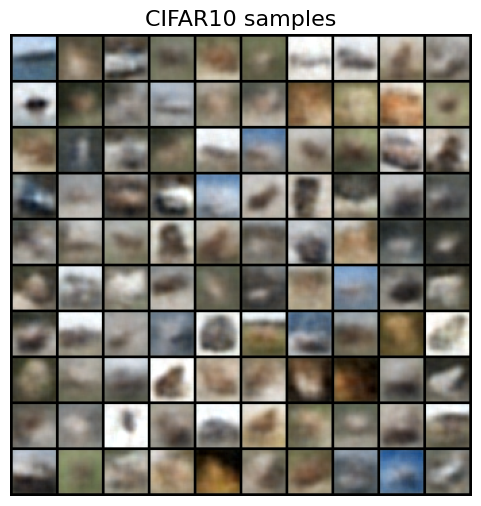

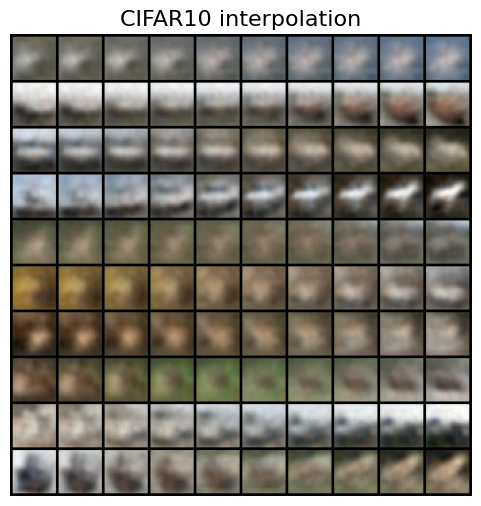

In [ ]:
samples = model.sample(100)

x = next(iter(test_loader))[:50]

x = x.to(model.device)

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x = next(iter(test_loader))[:20]
x = x.to(model.device)
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'CIFAR10 reconstructions')
show_samples(samples, 'CIFAR10 samples')
show_samples(interps, 'CIFAR10 interpolation')